<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/Week7_LectureSlide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FM 5222
# Week 7


# Multi-Colinearity 


In this lecture, we will focus on the issue of colinearity, how to detect it and what to do about it.


Multi-colinearity arises when the features $X$ are correlated to each other.  This makes the coefficient estimates highly variable since there is (possibly) "redundant" information in the data matrix $X$. It can also make the regressions themnselves highly sensitive to small changes in the data set.  Let us first think about this from a linear algrebra perspeticve

Our model is

$$Y = Xb + \epsilon$$

$X$ is our data matrix and it consists of $N$ rows and $p$ columns (assuming we do not have an intercept).

Typically, $N >p$ and we have therefore just assumed that $X^TX$ was rank $p$ and therefore invertible.   But suppose that instead of just being correlated, we actually had *exactly* that the $j$th feature was a linear combination of the other columns.  This would  imply that the rank of $X$ was less than $p$ and consequently $X^TX$ would **not** be invertible. 

However, even a small amount of noise in the $X$ would probably leave the rank of $X$ at $p$.  It would be *almost* not invertible. This is really what multi-colinearity is about.  Because $X^TX$ is nearly not invertible, $(X^TX)^{-1}$ it is numerically unstable and this causes issues with the entire regression.

In the end, multi-colinearity results from too many features being included in the model.


For the remainder, we will construct a model with data with built in colinearity and use it to illustrate the concepts.

## Fake Data Set

We start by building a data set with $3$ independent columns.  We then create a new data set with $5$ columns  that is just a linear combination of the first data set. This means that it will only have rank $3$.   Then we will add some noise which will make the data set have full rank, but not eliminate the colinearity.

We will have $100$ observations.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd


X0 = np.random.uniform(low = -10,high=10, size = [100,3])

A = np.array([[1,1,0,-1,2], [0,0,1,1,1], [-1,0,0,0,1]])  

X1 = X0@A

X1.shape, np.linalg.matrix_rank(X1)




((100, 5), 3)

In [ ]:
X = X1 + np.random.normal(size = X1.shape)

np.linalg.matrix_rank(X)

5

In [ ]:
sigma = 5

b = np.array([1,1,2,2,4])

Y = X@b + np.random.normal(scale = sigma, size = 100)

## How to detect multi-colinearity?


We have already discussed the Variance Inflation Factor of VIF.  We will calculate this shortly, but there are some other ways to check as well.


### Make paired comparisons




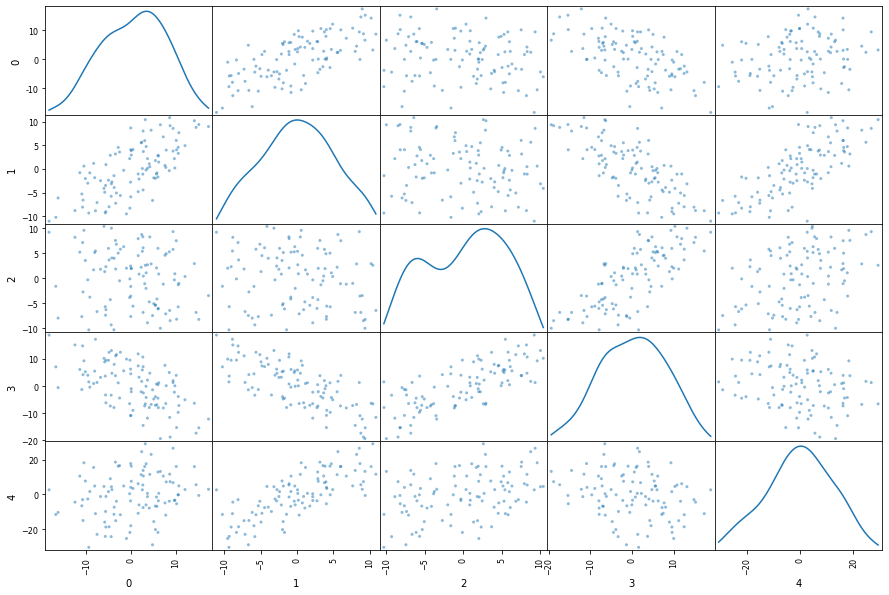

In [ ]:

pd.plotting.scatter_matrix(pd.DataFrame(X), figsize = (15,10),diagonal='kde' ,alpha=0.5)

plt.show()

Looking at the lower half, we see at least 4 pairs of features that are correlated positively or negatively.


Can also look at the correlation matrix directly.

In [ ]:
pd.DataFrame(X).corr()

,0,1,2,3,4
0,1.000000,0.694104,-0.162868,-0.571868,0.218980
1,0.694104,1.000000,-0.143255,-0.739041,0.751427
2,-0.162868,-0.143255,1.000000,0.745903,0.376919
3,-0.571868,-0.739041,0.745903,1.000000,-0.244336
4,0.218980,0.751427,0.376919,-0.244336,1.000000


Heat map:

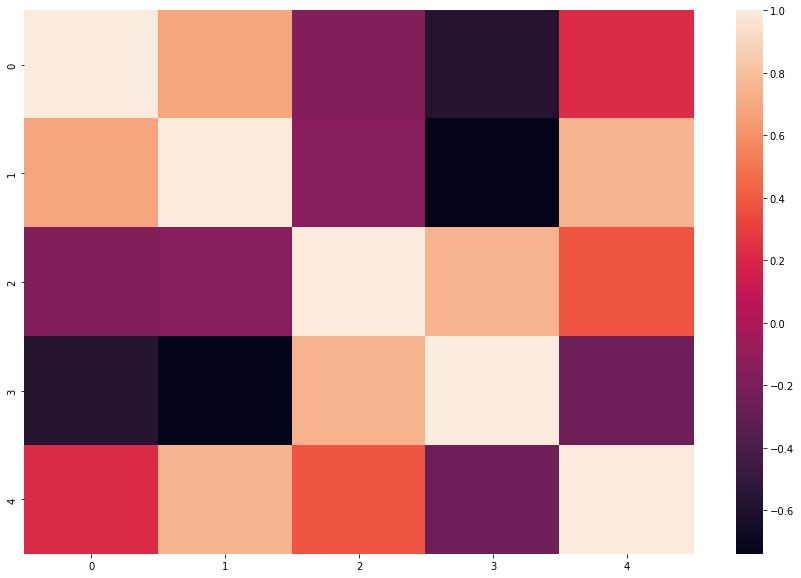

In [ ]:
import seaborn as sb

plt.figure(figsize = (15,10))
sb.heatmap(pd.DataFrame(X).corr())

plt.show()

### Calculate the VIFs

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
for idx in range(5):
    print(VIF(X,idx))

8.34501872827224
31.26580745876239
24.869721699527904
32.37543522571503
21.613607603632758


Remembering that a VIF larger than 4 suggests that the variable can be predicted by the other variables, this screams multi-colinearity.

Look at the condition number of $X^TX$.  The condition number is oftern large when a matrix is close to not being invertible.

In [ ]:
np.linalg.cond(X.T @X), np.log10(np.linalg.cond(X.T @X))

(275.47950330200285, 2.4400892912677117)

This is not a bad condition number.  So this method didn't help (but always worth checking).

## What to do about it

There are 3 methods I will describe here.  


1. Variable Selection using AIC (or BIC, etc)
2. PCA
3. LASSO regression

### Variable Selection using AIC.

The idea here is to select the best sub-model according to which one has the lowest AIC.  In this case, since there are $5$ variables, there are a total of $2^5$ possible models.  It is possible with a computer to span all of thees modelss and pick the one with the lowest AIC. But that can become infeasible quite quickly when the number of features becomes larger.  

A heuristic for finding a good model is called step regression. Step regression works as follows:

1. Calculate the base model's AIC. The base model here is $Y = 0 + \epsilon$

2. Calculcate the AIC of obstained by adding just one of each of the $5$ variables.  Select the model that does the best. If none improve the AIC, you are done.

3. Take the current winning model and add the one variable that improves the AIC the most.  Repeat until the model not longer improves.

This method is not guaranteed to find the best AIC.  But it is intuitive and less computationally expensive that a complete survey of all combinations of features.  

Python, to my knowledge, does not have a good step regressor.  However, R does. We uss that now to illustrate.


In [ ]:
# Create data frame to send over
data = pd.DataFrame(X, columns = ["X1","X2","X3","X4", "X5"])
data["Y"] = Y



In [ ]:
import rpy2.rinterface


%load_ext rpy2.ipython

In [ ]:
%%R -i data


head(data)




            X1         X2        X3          X4         X5          Y
0 -18.37591215 -11.052145  9.248591  18.8775074   2.689855  40.706451
1   0.42470647   4.078494 -5.543704  -8.9306057   3.484154 -14.514747
2 -16.35064669  -6.146294 -7.937663  -0.5329858 -10.330736 -81.757564
3  -4.92284996  -8.016461  3.703596  12.5041737 -18.626940 -56.447356
4  -0.10980969  -2.798872  2.482672   6.2918001  -3.701780  -2.939786
5  -0.05489973   4.039267 -7.628447 -10.7949694   4.106534 -12.591244


In [ ]:
%%R
NullModel <-  lm(formula = Y ~ 0 ,data = data )
FullModel <-  lm(formula =Y ~ 0+. ,data = data )

step(FullModel, scope= list(lower=NullModel, upper=FullModel), direction = 'both')

Start:  AIC=324.68
Y ~ 0 + (X1 + X2 + X3 + X4 + X5)

       Df Sum of Sq     RSS    AIC
- X2    1      15.8  2341.8 323.35
<none>               2326.0 324.68
- X4    1     408.2  2734.2 338.84
- X1    1     743.3  3069.3 350.40
- X3    1     887.2  3213.2 354.99
- X5    1   12240.8 14566.8 506.13

Step:  AIC=323.35
Y ~ X1 + X3 + X4 + X5 - 1

       Df Sum of Sq   RSS    AIC
<none>               2342 323.35
+ X2    1      15.8  2326 324.68
- X4    1     396.5  2738 336.99
- X3    1     871.7  3214 353.00
- X1    1    1852.3  4194 379.63
- X5    1   31126.6 33468 587.32

Call:
lm(formula = Y ~ X1 + X3 + X4 + X5 - 1, data = data)

Coefficients:
   X1     X3     X4     X5  
1.146  2.566  1.300  4.077  



In [ ]:
%%R

test <- lm(formula = Y ~ X5 + X3 + X1 + X4 - 1, data = data)

summary(test)


Call:
lm(formula = Y ~ X5 + X3 + X1 + X4 - 1, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.2256  -2.6743  -0.2405   2.7157  14.2762 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
X5   4.0775     0.1141  35.721  < 2e-16 ***
X3   2.5658     0.4292   5.978 3.85e-08 ***
X1   1.1463     0.1315   8.714 8.58e-14 ***
X4   1.2999     0.3224   4.032 0.000111 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.939 on 96 degrees of freedom
Multiple R-squared:  0.9939,	Adjusted R-squared:  0.9936 
F-statistic:  3884 on 4 and 96 DF,  p-value: < 2.2e-16



We can compare with OLS output

In [ ]:
import statsmodels.api as sm

model = sm.OLS(Y, np.delete(X,1,axis = 1))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              3884.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):                   3.32e-105
Time:                        00:21:40   Log-Likelihood:                         -299.57
No. Observations:                 100   AIC:                                      607.1
Df Residuals:                      96   BIC:                                      617.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1463      0.132      8.714      0.000       0.885       1.407
x2             2.5658      0.429      5.978      0.000       1.714       3.418
x3             1.2999      0.322      4.032      0.000       0.660       1.940
x4             4.0775      0.114     35.721      0.000       3.851       4.304
==============================================================================
Omnibus:                        3.191   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.844
Skew:                           0.412   Prob(JB):                        0.241
Kurtosis:                       3.047   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Standardizing

For the next two approaches, it is important to standardize the data before proceeding.  When standardizing, it's important to remember the transform so that you can translate back once you have built your model.

We will make the following transforms:

$U = \frac{X- \bar{X}}{s_X}$

and

$V = \frac{Y- \bar{Y}}{s_Y}$





In [ ]:
U = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)

U.mean(axis = 0), U.var(axis = 0)

(array([ 5.55111512e-17,  6.88338275e-17, -3.10862447e-17, -1.26565425e-16,
        -6.99440506e-17]), array([1., 1., 1., 1., 1.]))

In [ ]:
V = (Y - np.mean(Y, axis = 0))/np.std(Y, axis = 0)

V.mean(), V.var()

(5.551115123125783e-18, 1.0000000000000002)

### PCA

Principal Component Analysis (PCA) is a well-known dimension reduction method used in many applications.  We give a brief description here and work for our example.

The data matrix $U^TU$ is positive definite and symmetric so long as it is full rank.   Because $U$ was standardized, $\frac{1}{N}U^TU$ is the correlation matrix of the data variables $U = [u_1, u_2, ..., u_5]$.

Now suppose that we take a new set of data which is obtained via a linear transformation of the original variables $U$.  That is, we take

$$Z = UA$$

for some $5 \times m$ matrix $A$ where $1 \leq m \leq 5$

The covariance of $Z$ will be 

$$\mathrm{Cov}(Z) =\frac{1}{N} A^TU^TUA$$


We know from linear algebra that becaues $\frac{1}{N}U^TU$ is symmetric and positive definite, all of its eigenvalues $e_j$ are positive real numbers and its eigenvectors are orthogonal.

Furthermore, if $A$ is the matrix whose columns are eigvectors, then 


$$\frac{1}{N}A^TU^TUA = \mathrm{diag}(e_1,e_2,...,e_5)$$


The variance of each data vector $z_k$ is therefore the eigenvalue $e_k$.  Also, note that the correlations of the $z_k$ are all zero. This means we have no colinearity when we change variables from $U$ to $Z$. 

The variance of $z_1 + z_2 + \cdots + z_5$ is the sum of the eigenvalues and can be thought of, in some sense, the the total variance of the features.    If we order the eigenvectors according to the eigenvalues - largest to smallest, then we are capturing the first the "direction" that captures the most of the variance, then the second most, and so forth.   Typically, for some $m < 5$(or $p$ more generally), we will have captured nearly all of the variance.  Hence, we just use the first $m$ eigenvectors perform our regression using them.

Let's try this.





In [ ]:
e, A = np.linalg.eig(U.T@U/100)

In [ ]:
# Checking that A is orthogonal.  We find the numpy conveniently scaled it for us.
np.round(A@A.T,6)

array([[ 1.,  0.,  0.,  0., -0.],
       [ 0.,  1., -0.,  0.,  0.],
       [ 0., -0.,  1., -0.,  0.],
       [ 0.,  0., -0.,  1.,  0.],
       [-0.,  0.,  0.,  0.,  1.]])

In [ ]:
# Checking that things really diagonlalize

np.round(A.T@U.T@U@A/100,3), np.round(np.diag(e),3)

(array([[ 2.758, -0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.606,  0.   ,  0.   , -0.   ],
        [ 0.   ,  0.   ,  0.601, -0.   , -0.   ],
        [ 0.   ,  0.   , -0.   ,  0.015,  0.   ],
        [ 0.   , -0.   , -0.   , -0.   ,  0.021]]),
 array([[2.758, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 1.606, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.601, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.015, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.021]]))

Now we can see how much of the variance we can capture 

In [ ]:
e.cumsum()/e.sum()

array([0.55156016, 0.87269914, 0.99289651, 0.99585229, 1.        ])

We can see here that PCA suggests that we only need the first three components. Let regress then.

In [ ]:
Z = U@A

modelPCA = sm.OLS(V, Z[:,0:4])
resultPCA = modelPCA.fit()

resultPCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              3441.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):                   1.08e-102
Time:                        00:46:40   Log-Likelihood:                          106.72
No. Observations:                 100   AIC:                                     -205.4
Df Residuals:                      96   BIC:                                     -195.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1877      0.005    -36.692      0.000      -0.198      -0.178
x2            -0.7404      0.007   -110.449      0.000      -0.754      -0.727
x3            -0.1491      0.011    -13.607      0.000      -0.171      -0.127
x4             0.3965      0.070      5.675      0.000       0.258       0.535
==============================================================================
Omnibus:                        1.648   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.663
Skew:                           0.297   Prob(JB):                        0.435
Kurtosis:                       2.782   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Which we can compare with

In [ ]:
model = sm.OLS(V, U)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              3102.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):                   1.47e-103
Time:                        00:46:45   Log-Likelihood:                          113.17
No. Observations:                 100   AIC:                                     -216.3
Df Residuals:                      95   BIC:                                     -203.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1268      0.023      5.489      0.000       0.081       0.173
x2             0.0356      0.045      0.795      0.428      -0.053       0.124
x3             0.2410      0.040      6.036      0.000       0.162       0.320
x4             0.1851      0.046      4.058      0.000       0.095       0.276
x5             0.8329      0.037     22.380      0.000       0.759       0.907
==============================================================================
Omnibus:                        3.032   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.764
Skew:                           0.407   Prob(JB):                        0.251
Kurtosis:                       2.992   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LASSO Regression


The concept here comes from Machine Learning with a little bit of Occam's razor.

We wish to use the prediction variables to predict our target.  But we prefer to not have "large" coefficients and perhaps to drop some of the features we don't really need.  Normally, we would minimize the sum squared resisudals

$$J = \sum_{i=1}^N \hat{\epsilon}_i^2$$

We call the function $J(\mathbf{b})$ the penality function. In the standard case, there is only a  penality for the regeression fit to the data.

But in LASSO regression, we introduce an additional penalty for having using $b$ vector values that are too big. So we define the penality function

$$J(\mathbf{b};\alpha) = \sum_{i=1}^N \hat{\epsilon}_i^2 + \alpha \sum_{k=1}^p |b_p|$$

where $\mathbf{b} = [b_1,b_2,...,b_p]^T$

We have to choose $\alpha >0$.  If alpha is large, we end up selecting none of the variables.  And if $\alpha$ is small, we end up keeping them all.   But there is typically  a range of $\alpha$'s that will kick out some of the regressed coefficients $b_k$ (that is, set them to zero).


The package SKLearn has this built in.  So we use it here to demonstrate.



In [ ]:
from sklearn import linear_model



We first just linearly regress U and V like we normally would,but in sklearn, we input $X$ then $Y$ (or $U$ then $V$.

In [ ]:
reglin =  linear_model.LinearRegression()

reglin.fit(U,V)

reglin.coef_



array([0.12677012, 0.03560498, 0.24097529, 0.18507956, 0.83286219])

In [ ]:
regLASSO = linear_model.Lasso(alpha=0.5)
regLASSO.fit(U,V)

regLASSO.coef_


We see here, the penalty is to harsh.  We weaken it.


In [ ]:
regLASSO = linear_model.Lasso(alpha=.00001)
regLASSO.fit(U,V)

regLASSO.coef_

array([0.12665138, 0.03545688, 0.24141346, 0.18452194, 0.83268808])

How to we pick the penalty strength?  There is no hard and fast rule. One common approach is to use Cross Validation to "tune" the parameter $\alpha$.

## In Class Exercise and homework.

Pull tickers for 15 stocks plus the S&P500.   Take the stocks to be


3M, USbank, Target, Best Buy, Ford, GM, Microsoft, Intel, Apple, General Mills, Boeing, Disney, BP, C.H. Robinson, and Xcel.  

Calculate the log-returns over the last $5$ years.  

Consider the regression problem of predicting the S&P500 log-return given the log-returns of the 15 stocks. 

1. Identify any dates that have high leverage, a large Cook's distance or appear to be outliers.

2. Show evidence of multi-colinearity.

2. Do you need all 15 stocks for a good regression? Construct what you think is the "best" model for this.








In [ ]:
Disney